<a href="https://colab.research.google.com/github/willpanderson/Auto-Learn/blob/master/Separate_Testing_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import numpy as np
import pandas as pd
import traceback
import textwrap


In [0]:
pd.set_option("display.precision", 8)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_root='/content/drive/My Drive/TFLITE/car_images'
validation_root = '/content/drive/My Drive/TFLITE/Testing Data' ###

In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
VALIDATION_DATA_DIR = str(validation_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR, 
subset="validation",
shuffle=True,
target_size= IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/TFLITE/car_images
Found 472 images belonging to 6 classes.
Found 1904 images belonging to 6 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)
['Convertible' 'Coupe' 'Sedan' 'Suv' 'Truck' 'Van']


In [12]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
Dense(256, activation = 'relu'),
Dense(128, activation = 'relu'),
Dense(6, activation = 'softmax')
])

model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  327936    
_________________________________________________________________
dense_4 (Dense)              multiple                  32896     
_________________________________________________________________
dense_5 (Dense)              multiple                  774       
Total params: 2,619,590
Trainable params: 361,606
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=3,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


Epoch 1/3
60/60 [==============================] - ETA: 0s - loss: 0.1904 - acc: 0.9291

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


60/60 [==============================] - 24s 392ms/step - loss: 0.1904 - acc: 0.9291 - val_loss: 0.3943 - val_acc: 0.8835
Epoch 2/3
60/60 [==============================] - 23s 390ms/step - loss: 0.1688 - acc: 0.9364 - val_loss: 0.4795 - val_acc: 0.8432
Epoch 3/3
60/60 [==============================] - 24s 394ms/step - loss: 0.1564 - acc: 0.9449 - val_loss: 0.3441 - val_acc: 0.8856


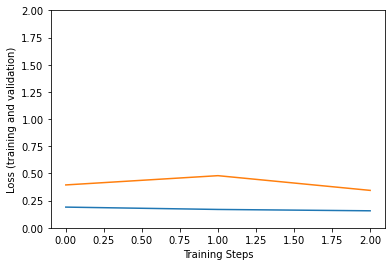

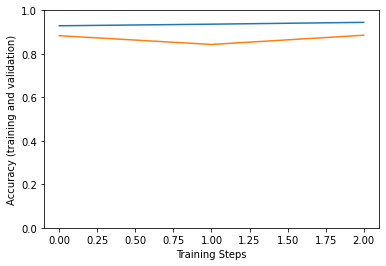

In [15]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [16]:
CAR_SAVED_MODEL = "/content/drive/My Drive/TFLITE/Saved Model(R)"
tf.saved_model.save(model, CAR_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLITE/Saved Model(R)/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLITE/Saved Model(R)/assets


In [9]:
# Load SavedModel
CAR_SAVED_MODEL = "/content/drive/My Drive/TFLITE/Saved Model(R)"
car_model = hub.load(CAR_SAVED_MODEL)
print(car_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f2496cc1390>


In [10]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [11]:
tf_model_predictions = car_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 6)


In [12]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Convertible,Coupe,Suv,Sedan,Truck,Van
0,0.00000073,0.00000006,0.04245705,0.00010741,0.95743382,0.00000092
1,0.00183874,0.00151516,0.01540337,0.97642547,0.00451896,0.00029832
2,0.00020035,0.99894148,0.00000593,0.00085219,0.00000012,0.00000002
3,0.00001256,0.00026465,0.97520679,0.02424279,0.00007708,0.00019629
4,0.00006699,0.00002843,0.00359648,0.00038098,0.99592292,0.00000415


In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

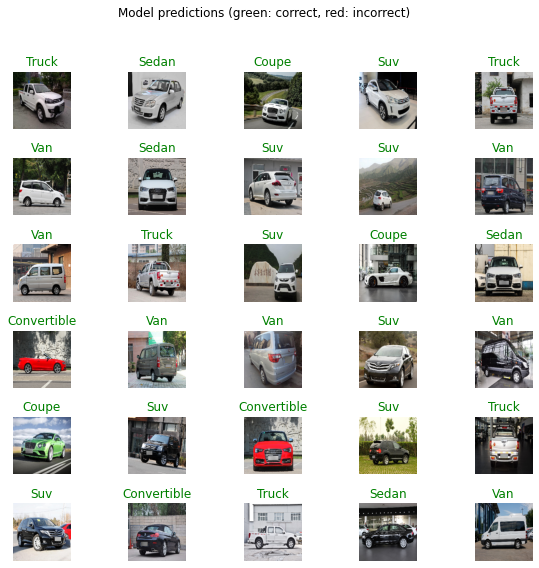

In [14]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/car.tflite"
TFLITE_QUANT_MODEL = "tflite_models/car_quant.tflite"
model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(224, 224, 3))
run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

mkdir: cannot create directory ‘tflite_models’: File exists


In [0]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 17M
-rw-r--r-- 1 root root 3.5M Apr 22 11:50 car_quant.tflite
-rw-r--r-- 1 root root  14M Apr 22 11:50 car.tflite
